## Read and combine datasets

In [2]:
def format_ecco(input):

    output = (input.rename({'dep': 'z'})
              .drop(['lon', 'lat'])
              .rename({'i1': 'time', 'i2': 'depth'}))
    output['depth'] = output['z']
    output['i4'] = input['lon'].values[0,:].squeeze()
    output['i3'] = input['lat'].values[:,0].squeeze()
    
    output = (output
              .rename({'i4': 'lon', 'i3': 'lat'})
              .drop(['z'])
              .set_coords(['lon', 'lat']))
    
    #wpac = output.sel(lon=slice(120,180)).copy()
    #wpac['lon'] -= 360
    
    return output

ρfile = '../ecco/interp_climatology/RHOAnoma.0001.nc'
Sfile = '../ecco/interp_climatology/SALT.0001.nc'
Tfile = '../ecco/interp_climatology/THETA.0001.nc'

T = xr.open_dataset(Tfile, autoclose=True, decode_cf=False).pipe(format_ecco)
S = xr.open_dataset(Sfile, autoclose=True, decode_cf=False).pipe(format_ecco)
ρ = xr.open_dataset(ρfile, autoclose=True, decode_cf=False).pipe(format_ecco)

ecc = xr.merge([T, S, ρ])

annual = ecc.mean(dim='time')

# Duplicate so that Pacific is complete
wpac = annual.sel(lon=slice(120,180)).copy()
wpac['lon'] -= 360
annual = xr.merge([wpac, annual])

ecc

<xarray.Dataset>
Dimensions:   (depth: 50, lat: 360, lon: 720, time: 12)
Coordinates:
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
  * depth     (depth) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.0 85.03 ...
  * lat       (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
Data variables:
    THETA     (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    tim       (time) float64 15.0 46.0 75.0 106.0 136.0 167.0 197.0 228.0 ...
    SALT      (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    RHOAnoma  (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...

In [18]:
ecc.RHOAnoma

<xarray.DataArray 'RHOAnoma' (time: 12, depth: 50, lat: 360, lon: 720)>
array([[[[      nan, ...,       nan],
         ...,
         [-2.96627 , ..., -2.965734]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]],


       ...,


       [[[      nan, ...,       nan],
         ...,
         [-3.111543, ..., -3.110993]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]])
Coordinates:
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
  * depth    (depth) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.0 85.03 ...
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
Attributes:
    long_name:    Density Anomaly (=Rho-rhoConst) (climatology) 
    units:        kg/m^3
    coordinates:  lon lat dep tim

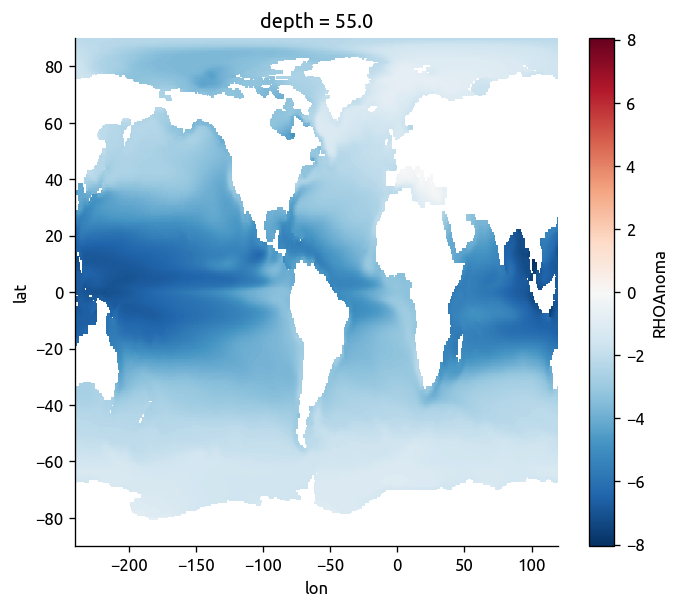

In [4]:
(annual.RHOAnoma
 .sel(depth=50, method='nearest')
 .plot(x='lon', y='lat'))

## P06

In [5]:
annual.THETA.coords

Coordinates:
  * lon      (lon) float64 -239.8 -239.2 -238.8 -238.2 -237.8 -237.2 -236.8 ...
  * depth    (depth) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.0 85.03 ...
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...

In [51]:
def wrap_gradient(input):
    ''' Given an input DataArray, calculate gradients in three directions and return it.
    
        Output
        ======
        
        dx, dy, dz = gradients in x,y,z
    '''
    
    gradients = np.gradient(input, input['depth'], input['lat'], input['lon'])
    
    dims = ['depth', 'lat', 'lon']
    coords = input.coords
    grads = xr.Dataset()
    grads['dz'] = xr.DataArray(gradients[0], dims=dims, coords=coords)
    grads['dy'] = xr.DataArray(gradients[1], dims=dims, coords=coords)
    grads['dx'] = xr.DataArray(gradients[2], dims=dims, coords=coords)
    
    grads['mag'] = np.sqrt(grads.dx**2 + grads.dy**2 + grads.dz**2)
    
    return grads

def project_vector(vector, proj, kind):
    ''' Project 'vector' along 'proj'
    '''
    
    cosine = ((vector.dx * proj.dx + vector.dy * proj.dy + vector.dz * proj.dz) 
              / proj.mag / vector.mag)
    
    cosine.values[cosine.values > 1] = 1 # underflow?
    
    if kind == 'along':
        return vector.mag * cosine
        
    if kind == 'normal':
        sine = np.sin(np.arccos(cosine))
        return vector.mag * sine


# some tests
nx = 10; ny=20; nz=30;

a = xr.DataArray(np.reshape(np.arange(nx*ny*nz), [nz,ny,nx]),
                dims=['depth', 'lat', 'lon'],
                coords={'depth':np.arange(nz),
                       'lat':np.arange(ny),
                       'lon':np.arange(nx)})

b = xr.DataArray(np.reshape(np.arange(nx*ny*nz,0,-1), [nz,ny,nx]),
                dims=['depth', 'lat', 'lon'],
                coords={'depth':np.arange(nz),
                       'lat':np.arange(ny),
                       'lon':np.arange(nx)})

da = wrap_gradient(a)
db = wrap_gradient(b)

# projection along gradient should be magnitude
xr.testing.assert_allclose(project_vector(da, da, 'along'), 
                           da.mag)

# projection normal to gradient should be zero
xr.testing.assert_equal(project_vector(da, da, 'normal'), 
                        xr.zeros_like(da.dx))

<xarray.DataArray (depth: 30, lat: 20, lon: 10)>
array([[[200.252341, 200.252341, ..., 200.252341, 200.252341],
        [200.252341, 200.252341, ..., 200.252341, 200.252341],
        ...,
        [200.252341, 200.252341, ..., 200.252341, 200.252341],
        [200.252341, 200.252341, ..., 200.252341, 200.252341]],

       [[200.252341, 200.252341, ..., 200.252341, 200.252341],
        [200.252341, 200.252341, ..., 200.252341, 200.252341],
        ...,
        [200.252341, 200.252341, ..., 200.252341, 200.252341],
        [200.252341, 200.252341, ..., 200.252341, 200.252341]],

       ...,

       [[200.252341, 200.252341, ..., 200.252341, 200.252341],
        [200.252341, 200.252341, ..., 200.252341, 200.252341],
        ...,
        [200.252341, 200.252341, ..., 200.252341, 200.252341],
        [200.252341, 200.252341, ..., 200.252341, 200.252341]],

       [[200.252341, 200.252341, ..., 200.252341, 200.252341],
        [200.252341, 200.252341, ..., 200.252341, 200.252341],
        ...

In [27]:
dT = wrap_gradient(annual.THETA)
dS = wrap_gradient(annual.SALT)
dρ = wrap_gradient(annual.RHOAnoma)

# projection normal to density gradient dρ is along-density surface
dTiso = project_vector(dT, dρ, 'normal')
dTiso.name = 'Along-isopycnal ∇T'

dSiso = project_vector(dS, dρ, 'normal')
dSiso.name = 'Along-isopycnal ∇S'

/home/deepak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [36]:
%matplotlib qt

region = dict(lat=-25, method='nearest')

f, ax = plt.subplots(2,1,sharex=True, sharey=True)

f.set_size_inches(8.5, 10)

dTiso.sel(**region).plot(ax=ax[0], yincrease=False, cmap=mpl.cm.Reds)
(annual.THETA.sel(**region)
 .plot.contour(ax=ax[0], yincrease=False, levels=60, cmap=mpl.cm.RdYlBu_r))
(annual.RHOAnoma.sel(**region)
 .plot.contour(ax=ax[0], yincrease=False, levels=50, colors='k'))

(annual.SALT.sel(**region)
 .plot.contour(ax=ax[1], yincrease=False, levels=60, cmap=mpl.cm.RdYlBu_r))
(annual.RHOAnoma.sel(**region)
 .plot.contour(ax=ax[1], yincrease=False, levels=50, colors='k'))
dSiso.sel(**region).plot(ax=ax[1], yincrease=False, cmap=mpl.cm.Reds)

[aa.set_xlabel('') for aa in ax[:-1]];
plt.tight_layout()